In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from project1 import defs

train: pd.DataFrame = defs.load_asset_value("train")
test: pd.DataFrame = defs.load_asset_value("test")

2024-04-13 16:40:47 -0700 - dagster - DEBUG - system - Loading file from: /home/maguire/ucla/ece219/project1/project1/../data/train using PickledObjectFilesystemIOManager...
2024-04-13 16:40:47 -0700 - dagster - DEBUG - system - Loading file from: /home/maguire/ucla/ece219/project1/project1/../data/test using PickledObjectFilesystemIOManager...


In [2]:
import joblib

def load_glove (glove_path):
    embeddings_dict = {}
    with open(glove_path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    return embeddings_dict

glove_options = [
    ("../../data/glove.6B.50d.txt", 50),
    ("../../data/glove.6B.100d.txt", 100),
    ("../../data/glove.6B.200d.txt", 200),
    ("../../data/glove.6B.300d.txt", 300)
]
for glove_path, embedding_dimension in glove_options:
    embedding_dict = load_glove(glove_path=glove_path)
    joblib.dump(embedding_dict, f"../../data/glove.{embedding_dimension}d.embeddings_dict.pkl")

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from project1.utils.TextPreprocessor import TextPreprocessor
from project1.utils.GloveEmbedder import GloveEmbedder
from project1.utils.MetricsAnalyzer import MetricsAnalyzer

def build_pipe (glove_dict, glove_dim):
    pipe = Pipeline(
        steps=[
            ('preprocess', TextPreprocessor(type="lemm", n_jobs=2)),
            ("embed", GloveEmbedder(embedding_dict_path=glove_dict, embedding_dim=glove_dim, n_jobs=2)),
            ('classifier', SVC(C=100, probability=True, kernel="linear"))
        ]
    )
    return pipe

glove_dicts = [
    ("../../data/glove.50d.embeddings_dict.pkl", 50),
    ("../../data/glove.100d.embeddings_dict.pkl", 100),
    ("../../data/glove.200d.embeddings_dict.pkl", 200),
    ("../../data/glove.300d.embeddings_dict.pkl", 300)
]

glove_dims = []
testing_accuracy = []

for option in glove_dicts:
    pipe = build_pipe(option[0], option[1])
    pipe.fit(train['full_text'], train['root_label'])
    metrics = MetricsAnalyzer(pipe, test['full_text'], test['root_label'], pos_label="sports")
    acc = metrics.get_accuracy()
    glove_dims.append(option[1])
    testing_accuracy.append(acc)

/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/maguire/ucla/ece219/project1/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  retu

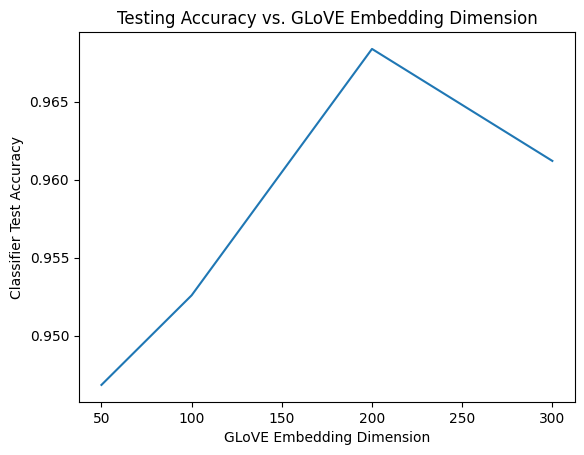

In [4]:
import matplotlib.pyplot as plt

plt.plot(glove_dims, testing_accuracy)
plt.xlabel("GLoVE Embedding Dimension")
plt.ylabel("Classifier Test Accuracy")
plt.title("Testing Accuracy vs. GLoVE Embedding Dimension")
plt.show()